## Interpretation of Hybrid VirProBERT attention values for multiclass classification

### Trainining Dataset: UNiRef90  - Coronaviridae Spike protein sequences aligned using MAFFT
### Interpretation: SARS-CoV-2 Spike protein sequences

**Models**: hybrid_attention_msl256_s64_fnn_2l_d1024_lr1e-4

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: -

**Classification**: Multi-class

**\# classes**: 8

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/..']

In [2]:
from models.nlp.transformer import transformer
from models.nlp.hybrid import transformer_attention
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, dataset_utils, nn_utils, constants

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

# from captum.attr import LayerIntegratedGradients, TokenReferenceBase, LayerGradientXActivation, LayerDeepLift, LayerLRP

In [3]:
label_groupings = {
                    "Chicken": [ "gallus gallus" ],
                    "Human": [ "homo sapiens" ],
                    "Cat": [ "felis catus" ],
                    "Pig": [ "sus scrofa" ],
                    "Gray wolf": [ "canis lupus" ],
                    "Horshoe bat": ["rhinolophus sp."],
                    "Ferret": ["mustela putorius"],
                    "Chinese rufous horseshoe bat": ["rhinolophus sinicus"]
                }


sequence_settings =  {
    "sequence_col": "aligned_seq",
    "batch_size": 16,
    "max_sequence_length": 128,
    "truncate": False,
    "split_sequence": False,
    "feature_type": "token",
}

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "pre_train_settings": {
        "n_heads": 8,
        "depth": 6,
        "input_dim": 512, # input embedding dimension
        "hidden_dim": 1024,
        "max_seq_len": 129,
    },
    "loss": "FocalLoss",
    "n_heads": 8,
    "depth": 2,
    "stride": 64,
    "n_classes": 8,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "cls_token": True
}

### Load the datasets

In [4]:
def print_dataset_loader(dataset_loader):
    print()
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")

In [5]:
input_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
uniref90_coronaviridae_aligned_df = pd.read_csv(input_file_path)
wiv04_seq_df = uniref90_coronaviridae_aligned_df[uniref90_coronaviridae_aligned_df["uniref90_id"] == "WIV04"]
uniref90_coronaviridae_aligned_df

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens
1,UniRef90_A0A7U3RIT3,--------------MFVFLVLVPLVSS--------Q----------...,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
2,UniRef90_A0A7U3HGG2,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
3,UniRef90_A0A7U3EEN6,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
4,UniRef90_A0A7U3HDM5,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
...,...,...,...,...,...,...
677,UniRef90_S5FZ76,---------------------------TLKQ---------------...,TLKQCDASAGYYSSSPIRPSDGVHSVTGFYRPVKTCCIKYTYPSNT...,Infectious bronchitis virus,gallus gallus,NOT homo sapiens
678,UniRef90_U5WLM9,--------------MLLLVTLFGLASG-------------------...,MLLLVTLFGLASGCSLPLTVSCPRGLPFTLQINTTSVTVEWYRVSP...,Sarbecovirus,rhinolophus sinicus,NOT homo sapiens
679,UniRef90_A0A169QA14,--MILHF-IMKVMPILIMVVFILL----------------------...,MILHFIMKVMPILIMVVFILLVYTNTHSSEWLLLFYFLISGVFCLY...,Infectious bronchitis virus,gallus gallus,NOT homo sapiens
680,UniRef90_E7DBM7,----------------------------------------------...,CSRRQFENYNQIEKVHVH,Feline coronavirus,felis catus,NOT homo sapiens


In [6]:
index_label_map, dataset_loader = dataset_utils.load_dataset_with_df(uniref90_coronaviridae_aligned_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")
print_dataset_loader(dataset_loader)

Grouping labels using config : {'Chicken': ['gallus gallus'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Pig': ['sus scrofa'], 'Gray wolf': ['canis lupus'], 'Horshoe bat': ['rhinolophus sp.'], 'Ferret': ['mustela putorius'], 'Chinese rufous horseshoe bat': ['rhinolophus sinicus']}
label_idx_map={'Cat': 0, 'Chicken': 1, 'Chinese rufous horseshoe bat': 2, 'Ferret': 3, 'Gray wolf': 4, 'Horshoe bat': 5, 'Human': 6, 'Pig': 7}
idx_label_map={0: 'Cat', 1: 'Chicken', 2: 'Chinese rufous horseshoe bat', 3: 'Ferret', 4: 'Gray wolf', 5: 'Horshoe bat', 6: 'Human', 7: 'Pig'}

Sequence tensor size = torch.Size([16, 2418])
Sequence = tensor([[27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.],
        ...,
        [27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 19., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.]], dtype=torch.float64)
Label tensor size = torch.Size([16])
Label = tensor([1

### Load the pre-trained and fine-tuned model

In [7]:
pre_train_encoder_settings = model["pre_train_settings"]
pre_train_encoder_settings["vocab_size"] = 30 #constants.VOCAB_SIZE
pre_trained_encoder_model = transformer.get_transformer_encoder(pre_train_encoder_settings)

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(30, 512, padding_idx=0)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0): ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
          (1): ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
 

In [8]:
model["pre_trained_model"] = pre_trained_encoder_model
model["segment_len"] = sequence_settings["max_sequence_length"]
prediction_model = transformer_attention.get_model(model)

TransformerAttention(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(30, 512, padding_idx=0)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0): ResidualConnectionLayer(
              (norm): NormalizationLayer()
            )
            (1): 

In [9]:
model_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_aligned_t0.01_c8/20240711/host_multi/fine_tuning_hybrid_cls_vs30/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_itr4.pth")
prediction_model.load_state_dict(torch.load(model_path, map_location=nn_utils.get_device()))

<All keys matched successfully>

### t-SNE Analysis

In [10]:
def compute_embeddings(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq)
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = model.embedding
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        print(seq_df.shape)
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

def view_tsne_representation(rep_df, index_label_map):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_tsne_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_tsne_emb.shape)
    print(X_tsne_emb)
    X_tsne_emb["label"] = rep_df["label"].values
    X_tsne_emb["label"] = X_tsne_emb["label"].map(index_label_map)
    
    sns.scatterplot(data = X_tsne_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    return tsne_model, X_tsne_emb

In [11]:
#emb_df = compute_embeddings(prediction_model, dataset_loader)

### Attention value Analysis

In [12]:
def analyze_attention_of_sequence(model, seq):
    print(f"sequence length = {seq_len}")
    model.eval()
    output = model(seq)
    

In [13]:
wiv04_seq_df

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [14]:
len(wiv04_seq_df["aligned_seq"][0])

2418

In [15]:
sequence_settings["batch_size"] = 1
sequence_settings["max_sequence_length"] = 128

_, wiv04_seq_df_dataset_loader = dataset_utils.load_dataset_with_df(wiv04_seq_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")

Grouping labels using config : {'Chicken': ['gallus gallus'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Pig': ['sus scrofa'], 'Gray wolf': ['canis lupus'], 'Horshoe bat': ['rhinolophus sp.'], 'Ferret': ['mustela putorius'], 'Chinese rufous horseshoe bat': ['rhinolophus sinicus']}
label_idx_map={'Cat': 0, 'Chicken': 1, 'Chinese rufous horseshoe bat': 2, 'Ferret': 3, 'Gray wolf': 4, 'Horshoe bat': 5, 'Human': 6, 'Pig': 7}
idx_label_map={0: 'Cat', 1: 'Chicken', 2: 'Chinese rufous horseshoe bat', 3: 'Ferret', 4: 'Gray wolf', 5: 'Horshoe bat', 6: 'Human', 7: 'Pig'}


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../../utils/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [16]:
prediction_model.eval()
input, label = next(iter(wiv04_seq_df_dataset_loader))

In [17]:
output = prediction_model(input)

In [18]:
output

tensor([[-11.2018,  -7.8662,   6.5910,  -6.0754,  -8.3555,   0.3542,   8.6569,
          -7.0038]], grad_fn=<AddmmBackward0>)

In [19]:
label

tensor([6])

In [20]:
F.softmax(output, dim=1)

tensor([[2.1065e-09, 5.9182e-08, 1.1242e-01, 3.5474e-07, 3.6283e-08, 2.1992e-04,
         8.8736e-01, 1.4020e-07]], grad_fn=<SoftmaxBackward0>)

In [21]:
prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn.shape

torch.Size([36, 8, 129, 129])

In [22]:
prediction_model.self_attn.self_attn.squeeze().shape

torch.Size([8, 36, 36])

In [23]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_seq_df["aligned_seq"][0]):
    if token == "-":
        pass
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
    if (i%64 == 0) and (i not in wiv04_position_mapping):
        wiv04_position_mapping[i] = pos        

In [24]:
len(wiv04_position_mapping)

1293

In [25]:
wiv04_position_mapping

{0: 0,
 14: 1,
 15: 2,
 16: 3,
 17: 4,
 18: 5,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 35: 14,
 52: 15,
 53: 16,
 54: 17,
 63: 18,
 64: 19,
 65: 20,
 66: 21,
 67: 22,
 68: 23,
 69: 24,
 70: 25,
 71: 26,
 72: 27,
 73: 28,
 78: 29,
 79: 30,
 80: 31,
 81: 32,
 82: 33,
 83: 34,
 84: 35,
 85: 36,
 86: 37,
 87: 38,
 88: 39,
 89: 40,
 90: 41,
 91: 42,
 92: 43,
 93: 44,
 94: 45,
 95: 46,
 96: 47,
 97: 48,
 98: 49,
 99: 50,
 100: 51,
 101: 52,
 102: 53,
 103: 54,
 104: 55,
 105: 56,
 106: 57,
 107: 58,
 124: 59,
 125: 60,
 126: 61,
 127: 62,
 128: 63,
 129: 64,
 130: 65,
 131: 66,
 132: 67,
 133: 68,
 134: 69,
 135: 70,
 136: 71,
 137: 72,
 138: 73,
 154: 74,
 155: 75,
 156: 76,
 157: 77,
 158: 78,
 159: 79,
 160: 80,
 161: 81,
 162: 82,
 163: 83,
 164: 84,
 165: 85,
 166: 86,
 167: 87,
 169: 88,
 170: 89,
 171: 90,
 172: 91,
 173: 92,
 174: 93,
 175: 94,
 176: 95,
 177: 96,
 178: 97,
 188: 98,
 189: 99,
 190: 100,
 191: 101,
 192: 102,
 193: 103,
 194: 104,
 195: 1

In [26]:
pos_mapping = {}
j = 0
for i in range(0, len(wiv04_seq_df["aligned_seq"][0]), 64):
    try:
        pos_mapping[j] = f"{j}: {wiv04_position_mapping[i]}-{wiv04_position_mapping[i+128]}"
    except KeyError:
        break
    j += 1

In [27]:
pos_mapping

{0: '0: 0-63',
 1: '1: 19-102',
 2: '2: 63-125',
 3: '3: 102-150',
 4: '4: 125-160',
 5: '5: 150-177',
 6: '6: 160-193',
 7: '7: 177-193',
 8: '8: 193-194',
 9: '9: 193-242',
 10: '10: 194-306',
 11: '11: 242-329',
 12: '12: 306-363',
 13: '13: 329-376',
 14: '14: 363-398',
 15: '15: 376-413',
 16: '16: 398-434',
 17: '17: 413-439',
 18: '18: 434-481',
 19: '19: 439-495',
 20: '20: 481-508',
 21: '21: 495-526',
 22: '22: 508-562',
 23: '23: 526-619',
 24: '24: 562-668',
 25: '25: 619-722',
 26: '26: 668-785',
 27: '27: 722-818',
 28: '28: 785-876',
 29: '29: 818-934',
 30: '30: 876-985',
 31: '31: 934-1048',
 32: '32: 985-1097',
 33: '33: 1048-1155',
 34: '34: 1097-1202',
 35: '35: 1155-1246'}

In [28]:
inter_seg_attn = prediction_model.self_attn.self_attn.squeeze()

<Figure size 432x288 with 0 Axes>

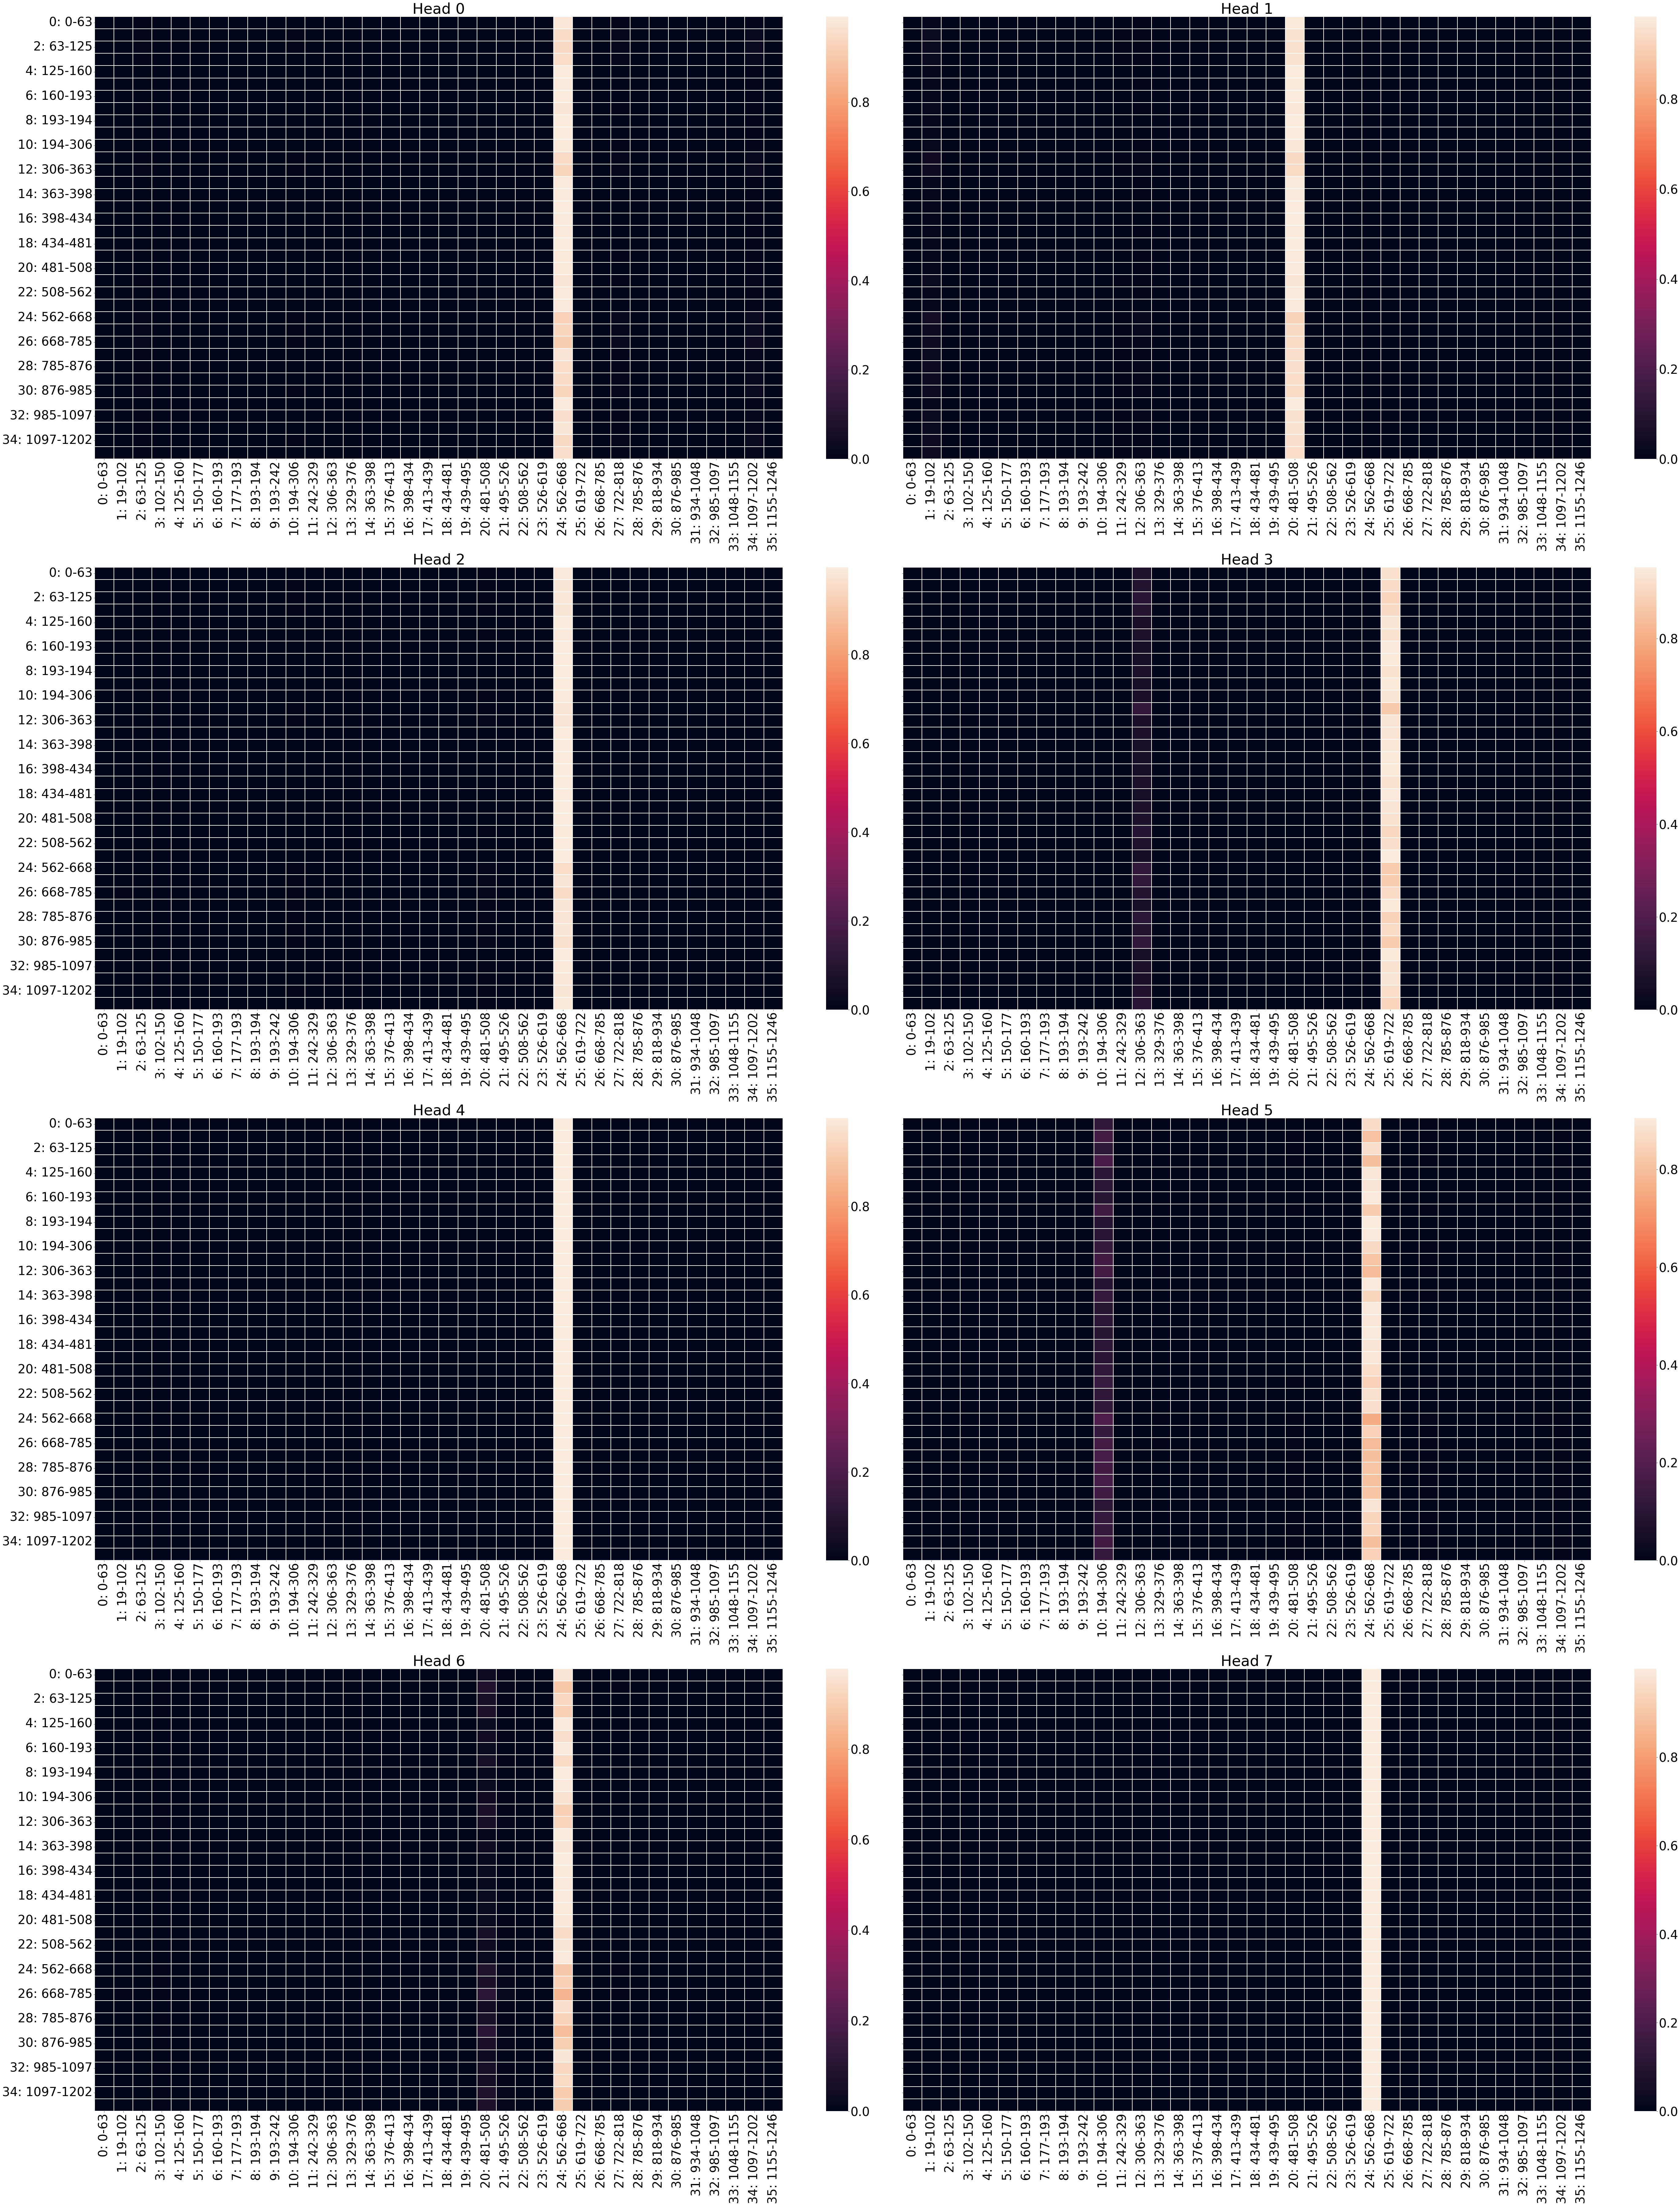

In [29]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=True)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(inter_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=pos_mapping, inplace=True)
        df.rename(index=pos_mapping, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()

In [44]:
intra_seg_index = 20
intra_seg_attn = prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn[intra_seg_index].squeeze()

In [45]:
intra_seg_attn.shape

torch.Size([8, 129, 129])

In [46]:
intra_seg_pos_map = {}
intra_seg_start = intra_seg_index * 64
intra_seg_end = intra_seg_index * 64 + 128

c = 0
for i in range(intra_seg_start, intra_seg_end + 1):
    if i in wiv04_position_mapping:
        intra_seg_pos_map[c] = wiv04_position_mapping[i]
    else:
        intra_seg_pos_map[c] = "-"
    c += 1

intra_seg_pos_map

{0: 481,
 1: '-',
 2: '-',
 3: '-',
 4: '-',
 5: '-',
 6: '-',
 7: '-',
 8: '-',
 9: '-',
 10: '-',
 11: '-',
 12: '-',
 13: '-',
 14: '-',
 15: '-',
 16: '-',
 17: '-',
 18: 482,
 19: 483,
 20: 484,
 21: 485,
 22: 486,
 23: 487,
 24: 488,
 25: '-',
 26: '-',
 27: '-',
 28: '-',
 29: '-',
 30: 489,
 31: 490,
 32: 491,
 33: 492,
 34: 493,
 35: 494,
 36: 495,
 37: '-',
 38: '-',
 39: '-',
 40: '-',
 41: '-',
 42: '-',
 43: '-',
 44: '-',
 45: '-',
 46: '-',
 47: '-',
 48: '-',
 49: '-',
 50: '-',
 51: '-',
 52: '-',
 53: '-',
 54: '-',
 55: '-',
 56: '-',
 57: '-',
 58: '-',
 59: '-',
 60: '-',
 61: '-',
 62: '-',
 63: '-',
 64: 495,
 65: 496,
 66: 497,
 67: 498,
 68: 499,
 69: 500,
 70: '-',
 71: '-',
 72: '-',
 73: '-',
 74: '-',
 75: '-',
 76: '-',
 77: '-',
 78: '-',
 79: '-',
 80: '-',
 81: '-',
 82: '-',
 83: '-',
 84: '-',
 85: '-',
 86: '-',
 87: '-',
 88: '-',
 89: '-',
 90: '-',
 91: '-',
 92: '-',
 93: '-',
 94: '-',
 95: '-',
 96: '-',
 97: '-',
 98: '-',
 99: '-',
 100: '-',

<Figure size 432x288 with 0 Axes>

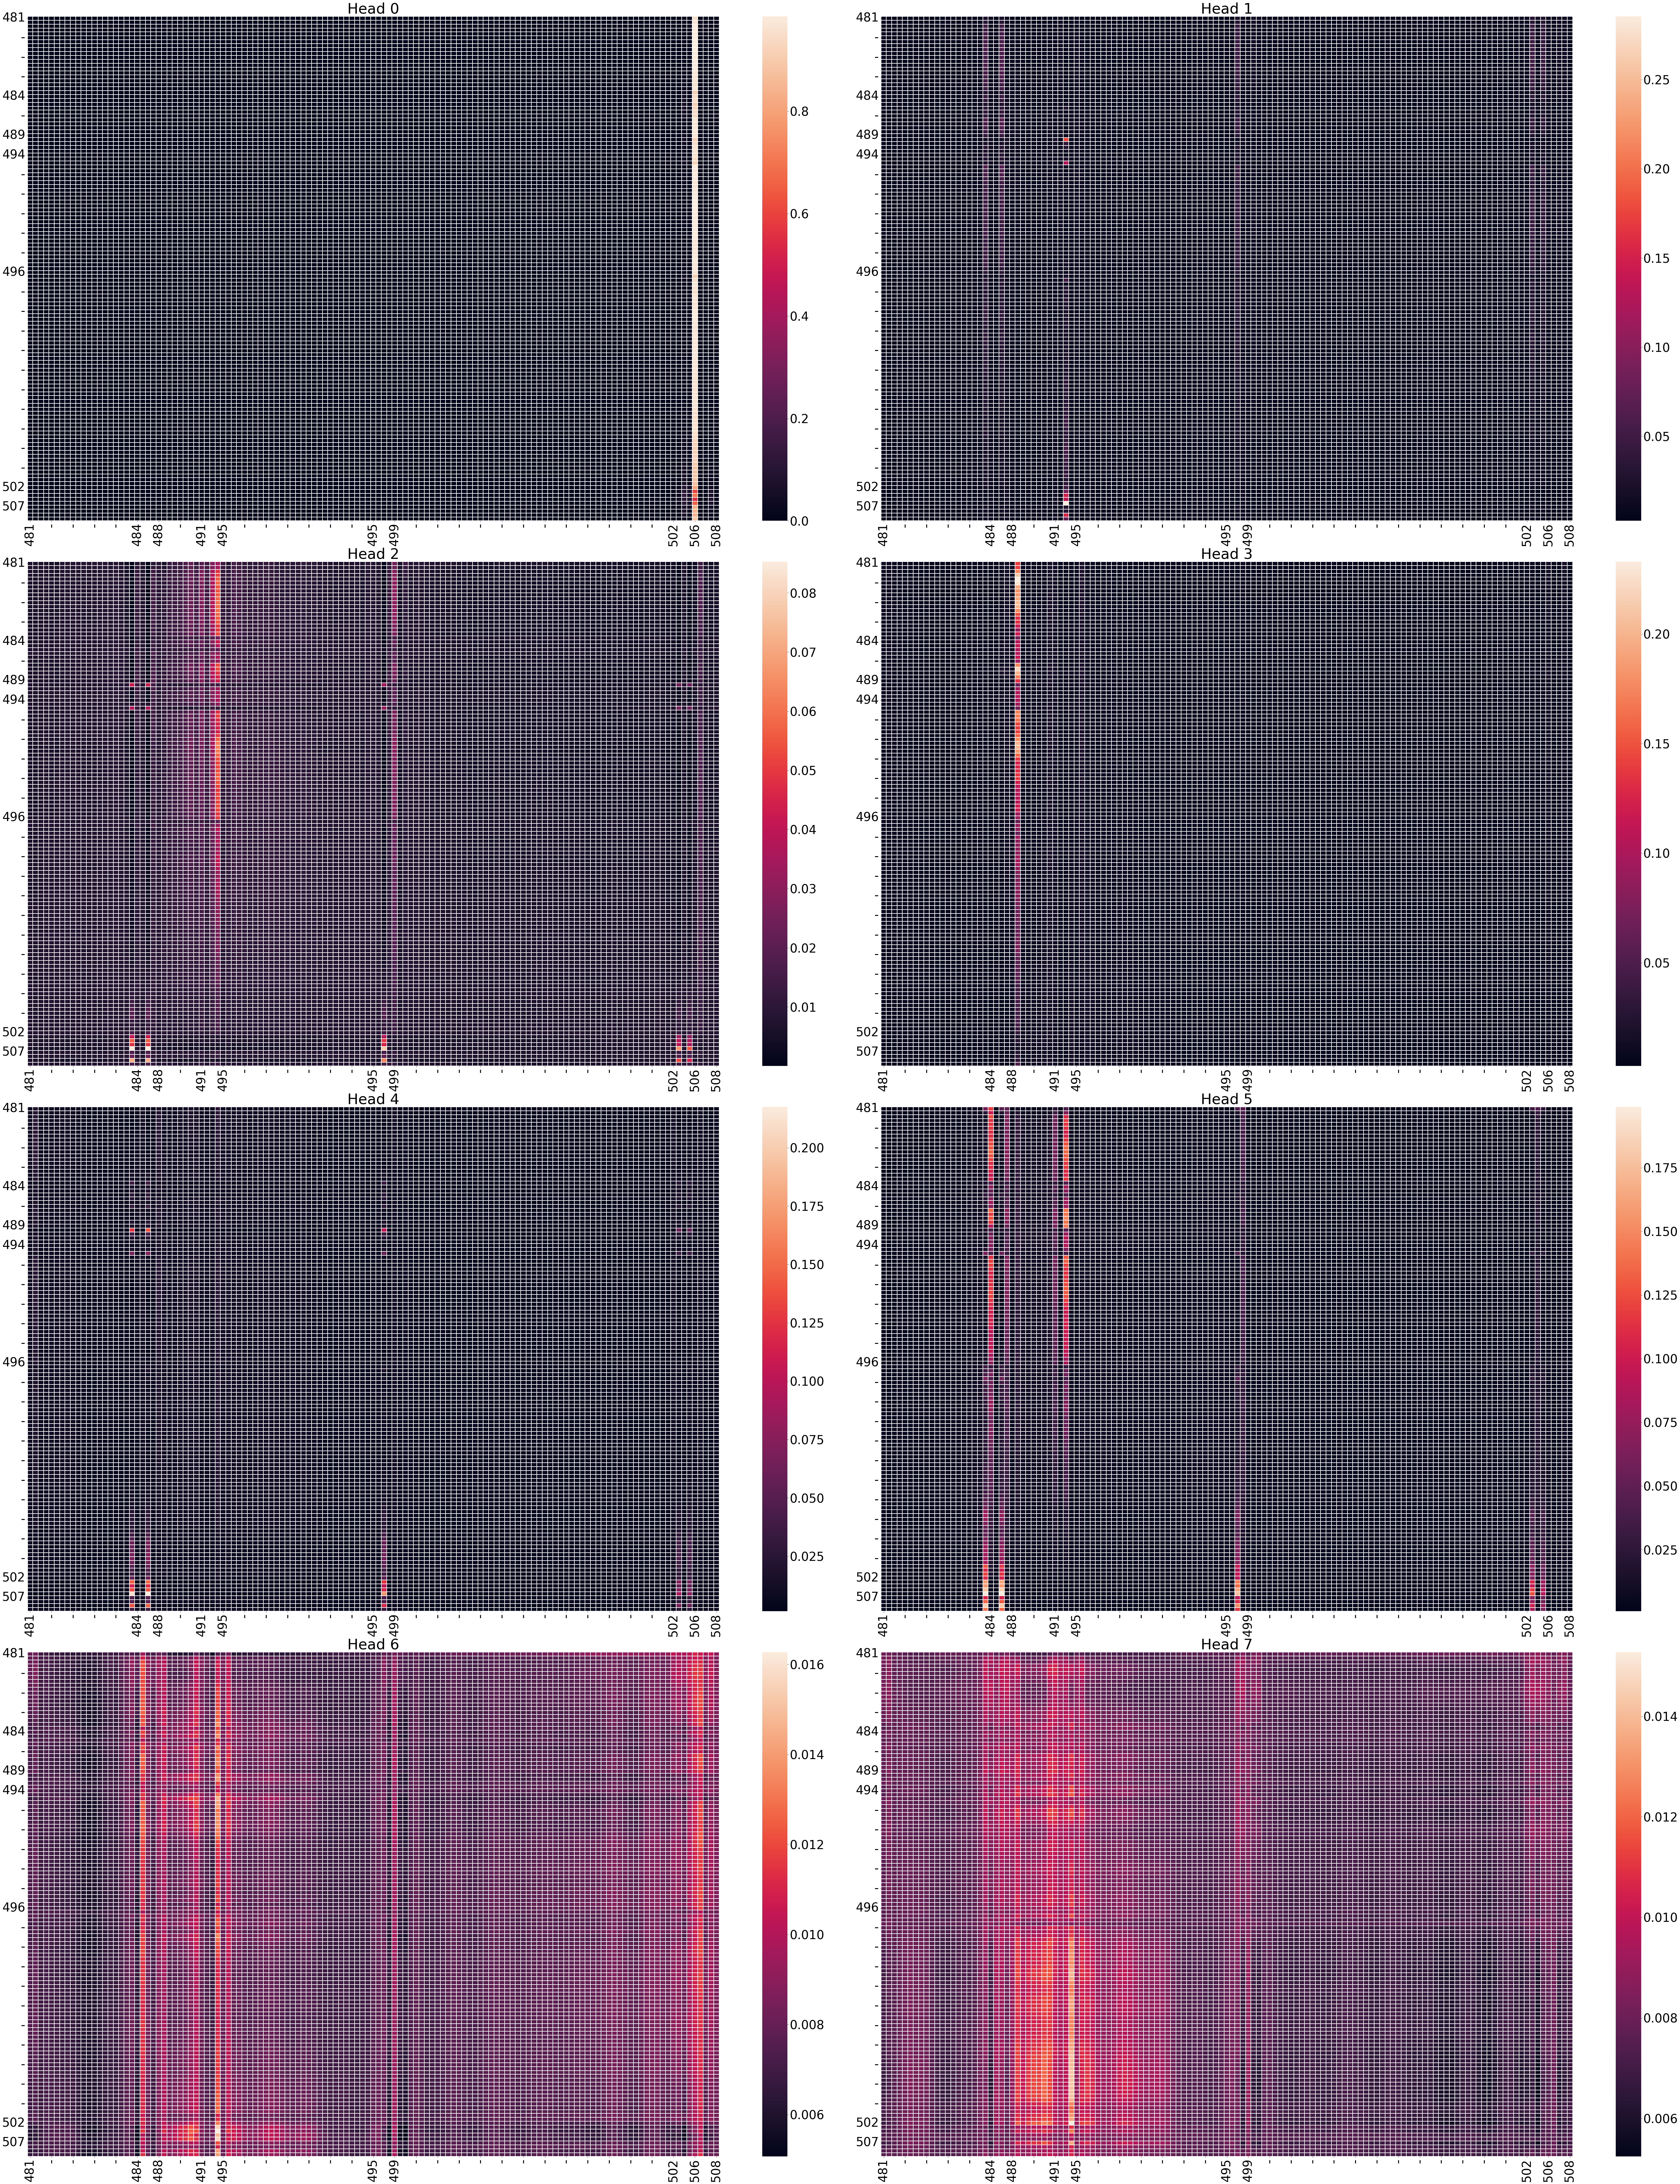

In [47]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=False)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(intra_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=intra_seg_pos_map, inplace=True)
        df.rename(index=intra_seg_pos_map, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()

<Figure size 432x288 with 0 Axes>

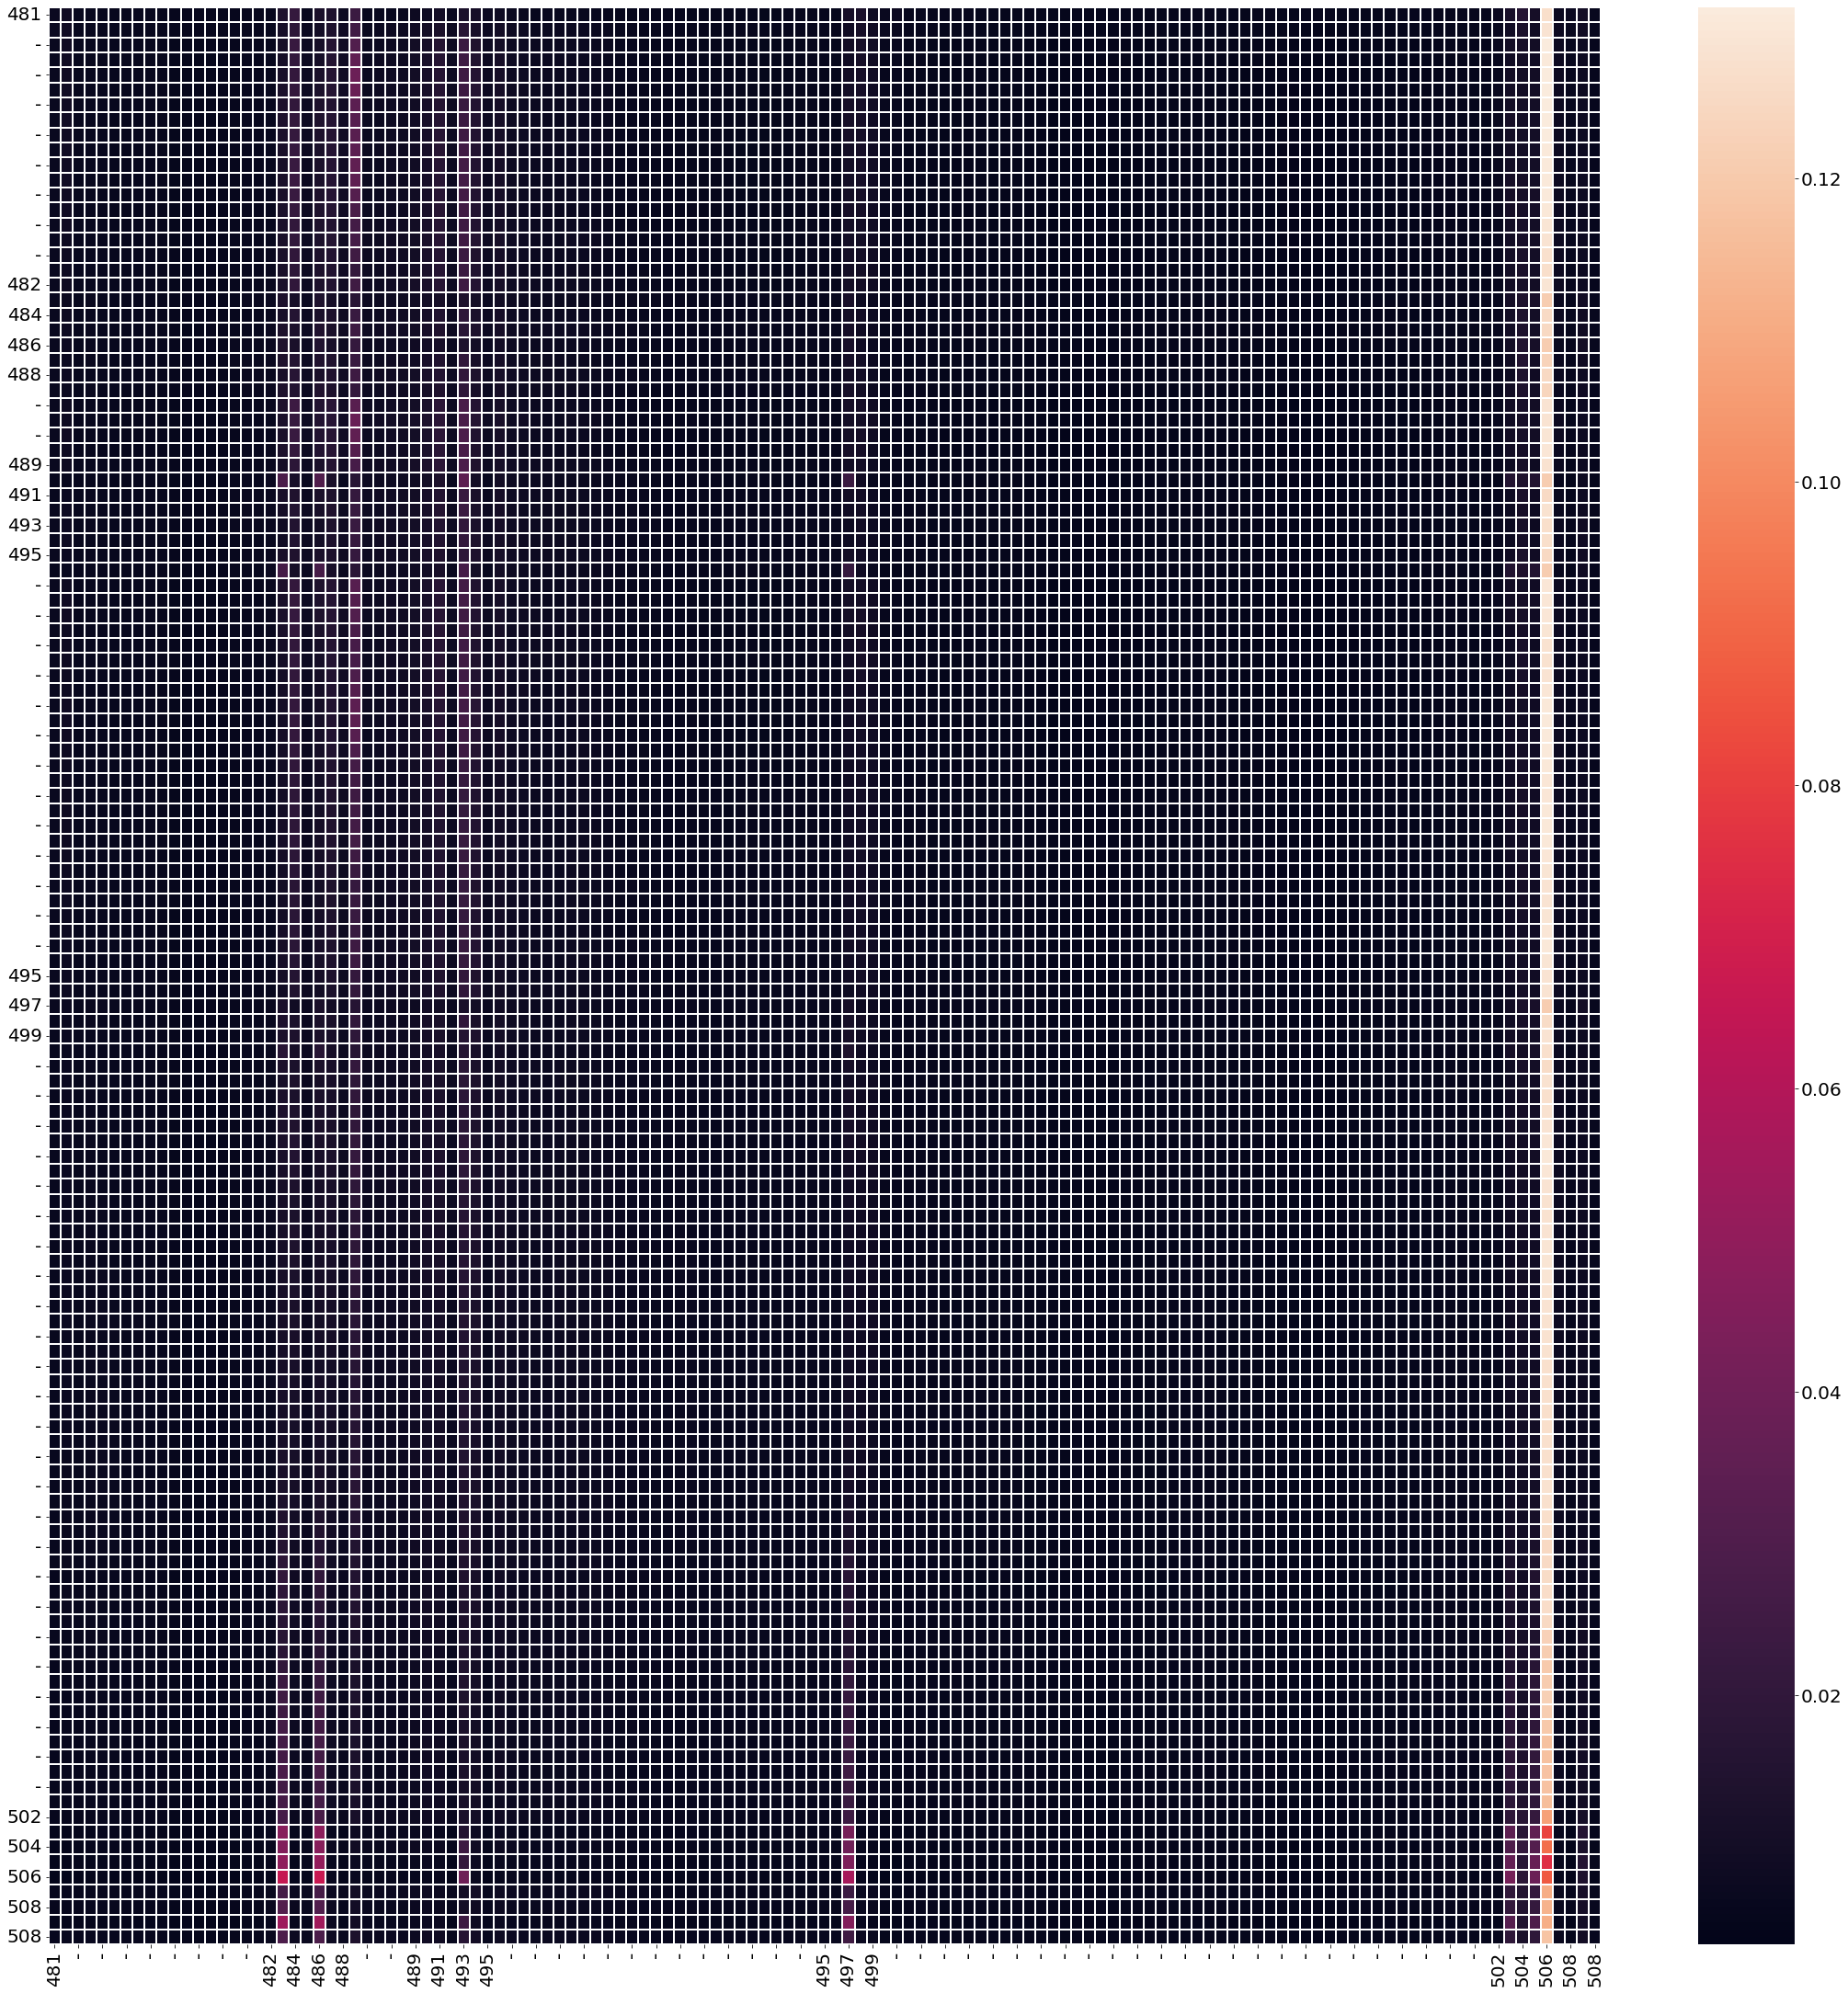

In [48]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 1, figsize=(30, 30), sharex=False, sharey=False)

df = pd.DataFrame(intra_seg_attn.mean(dim=0).detach().cpu().numpy())
df.rename(columns=intra_seg_pos_map, inplace=True)
df.rename(index=intra_seg_pos_map, inplace=True)
sns.heatmap(df, ax=axs, linewidth=.1)

plt.tight_layout(pad=.1)
plt.show()

In [49]:
non_dash_indices = [k for k, v in intra_seg_pos_map.items() if v != "-" ]

<Figure size 432x288 with 0 Axes>

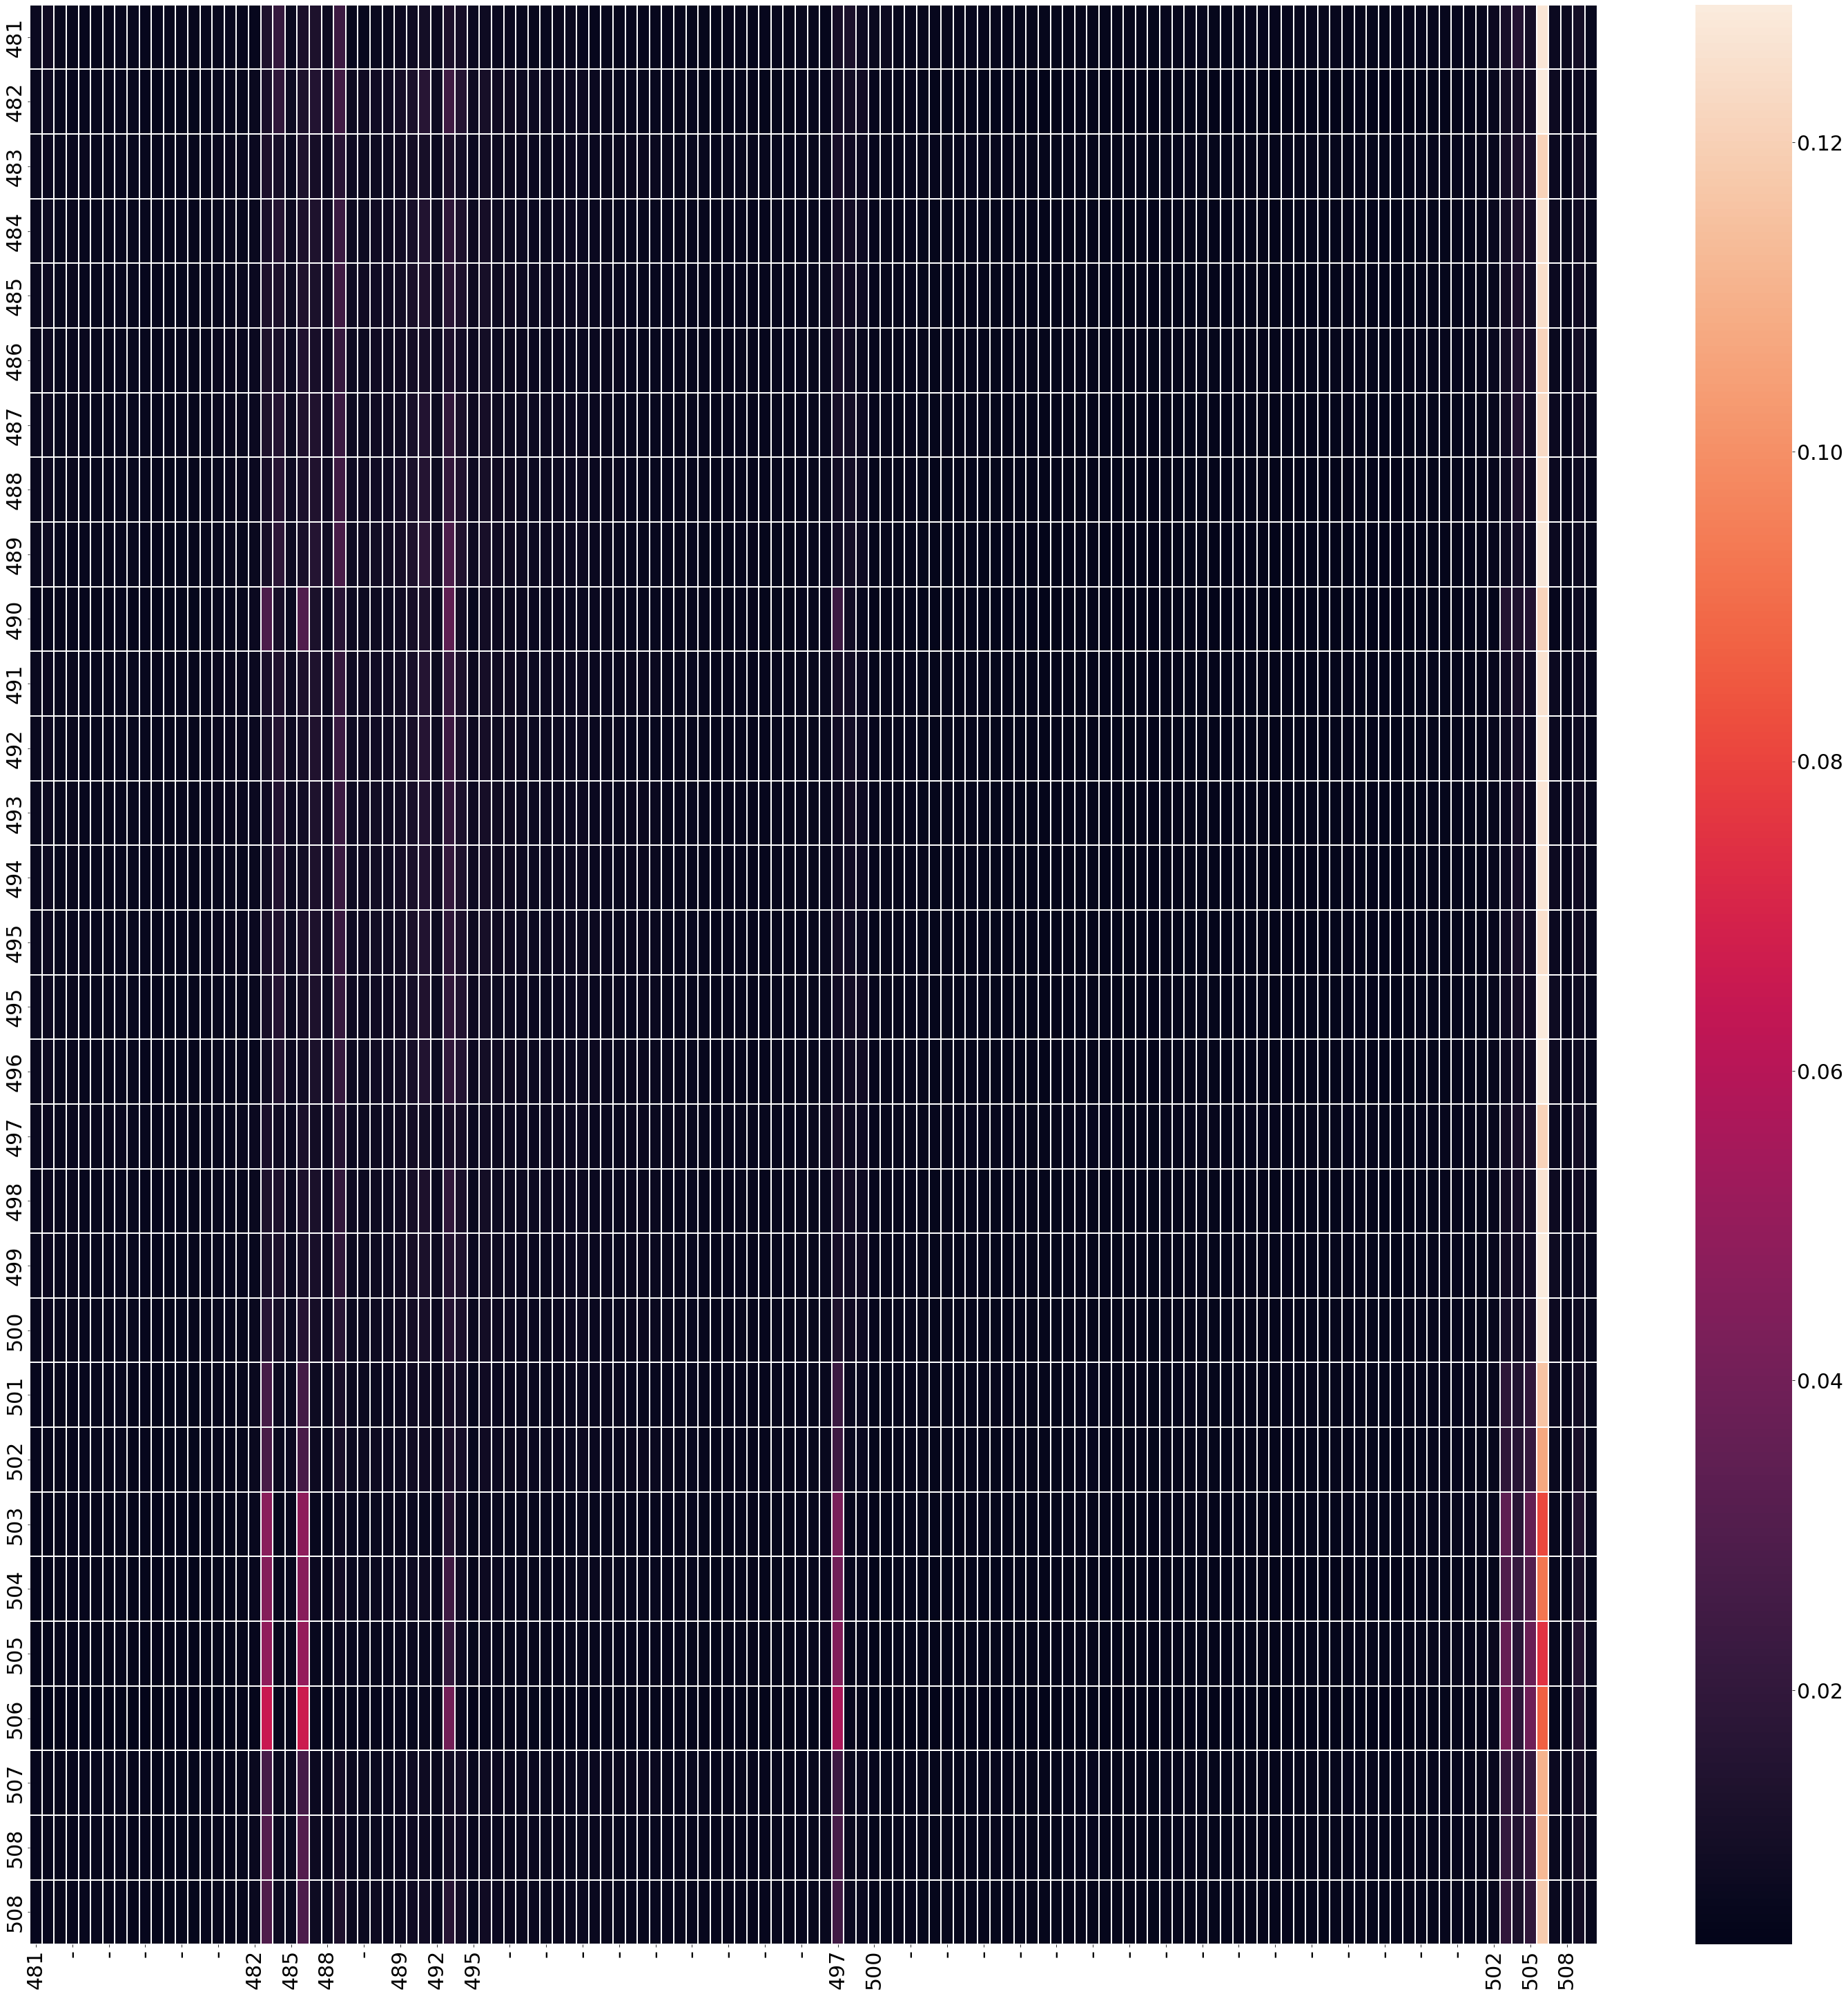

In [50]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 1, figsize=(40, 40), sharex=False, sharey=False)

df = pd.DataFrame(intra_seg_attn.mean(dim=0).detach().cpu().numpy())
df = df.iloc[non_dash_indices]
df.rename(columns=intra_seg_pos_map, inplace=True)
df.rename(index=intra_seg_pos_map, inplace=True)
sns.heatmap(df, ax=axs, linewidth=.1)

plt.tight_layout(pad=.1)
plt.show()